In [41]:
import itertools
import pandas as pd
import numpy as np
import scipy.stats
import re
import math
import matplotlib as mlp
import matplotlib.pyplot as plt
import matplotlib.backends.backend_agg
import matplotlib.figure
import seaborn as sns
import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.metrics import roc_curve, roc_auc_score

In [42]:
cars_dataset = pd.read_csv('C:/Users/aleja/Cars-Value-Predictor/cars-features-dataset.csv')
cars_dataset.drop(columns='Unnamed: 0', inplace=True)
print(cars_dataset.shape)
cars_dataset.head()

(16920, 18)


,Make,Model,Year,Mileage,Transmission,Engine,Exterior Color,Interior Color,MPG,Fuel Type,Drive Type,Location (City),Location (State),Style,Condition (Accidents),Options Level,Bed Length,Price
0,Ford,Focus,2014.0,"35,795",Automatic,2.0L Inline-4 Gas,NaN,Charcoal Black,26 cty / 36 hwy,Gas,FWD,Tacoma,WA,SE Hatchback,2 reported accidents,Standard,NaN,"7,999"
1,Ford,F-150,2015.0,"128,146",Automatic,2.7L V-6 Gas Turbocharged,Unknown,Medium Earth Gray,19 cty / 26 hwy,Gas,RWD,Waxahachie,TX,XL SuperCrew 6.5\' Box RWD,0 reported accidents,NaN,Standard Bed,"15,991"
2,Mercedes-Benz,E-Class,2004.0,"135,000",Automatic,5.0L V-8 Gas,Black,Beige,16 cty / 22 hwy,Gas,AWD,Covina,CA,E 500 4MATIC Wagon,0 reported accidents,Standard,NaN,"5,950"
3,Hyundai,Elantra,2011.0,"135,670",Automatic,1.8L Inline-4 Gas,NaN,Gray,28 cty / 38 hwy,Gas,FWD,Miami,FL,NaN,0 reported accidents,Standard,NaN,"3,999"
4,Toyota,Prius,2012.0,"152,543",Automatic,1.8L Inline-4 Hybrid,White,Biege,51 cty / 48 hwy,Hybrid,FWD,Byhalia,MS,Five,1 reported accidents,Standard,NaN,"6,500"


## Exploratory Data Analysis

In [43]:
cars_dataset.isnull().sum(axis=0)

Make                       896
Model                      923
Year                       822
Mileage                    349
Transmission               386
Engine                    3545
Exterior Color            5840
Interior Color            1285
MPG                        367
Fuel Type                  336
Drive Type                 284
Location (City)            713
Location (State)           748
Style                     1747
Condition (Accidents)      781
Options Level             2241
Bed Length               15641
Price                      916
dtype: int64

In [44]:
cols_by_nulls = cars_dataset.isnull().sum().sort_values(ascending=False).to_dict()
cols_by_nulls

{'Bed Length': 15641,
 'Exterior Color': 5840,
 'Engine': 3545,
 'Options Level': 2241,
 'Style': 1747,
 'Interior Color': 1285,
 'Model': 923,
 'Price': 916,
 'Make': 896,
 'Year': 822,
 'Condition (Accidents)': 781,
 'Location (State)': 748,
 'Location (City)': 713,
 'Transmission': 386,
 'MPG': 367,
 'Mileage': 349,
 'Fuel Type': 336,
 'Drive Type': 284}

This high quantity of allegedly null values is due to lack of information when inputting specifications in each car listing from its owner or merchant.
Some of them will be dropped but most of them will be labeled as another data.

In [45]:
cars_dataset.dropna(subset=['Make', 'Model'], inplace=True)
cars_dataset.shape

(15983, 18)

Make and model are too important to have as an specific information for each row, so the ones were Make and Model are missing were dropped.

Now, 'Drive Type' will be analyzed. It has a lot less null values, so they will be eliminated.

In [46]:
cars_dataset.dropna(subset=['Drive Type'], inplace=True)

In [47]:
cars_dataset.shape

(15960, 18)

In [48]:
print("'Bed Length' column has", cars_dataset["Bed Length"].isnull().sum(), "null values.")
print("The other ones (", cars_dataset["Bed Length"].notnull().sum(), ") are:", sep="")
cars_dataset['Bed Length'].value_counts()

'Bed Length' column has 14730 null values.
The other ones (1230) are:


Short Bed       576
Standard Bed    535
Long Bed        119
Name: Bed Length, dtype: int64

As seen above the bed length is null for almost all cases, so it will be discarded.

In [49]:
cars_dataset.drop(columns='Bed Length', inplace=True)
cars_dataset.columns

Index(['Make', 'Model', 'Year', 'Mileage', 'Transmission', 'Engine',
       'Exterior Color', 'Interior Color', 'MPG', 'Fuel Type', 'Drive Type',
       'Location (City)', 'Location (State)', 'Style', 'Condition (Accidents)',
       'Options Level', 'Price'],
      dtype='object')

In [50]:
cols_by_nulls.pop("Bed Length")

15641

In [51]:
print("Exterior Color has", cols_by_nulls['Exterior Color'], "null values")
print(cars_dataset['Exterior Color'].value_counts().sum(), "not null values and values count:", cars_dataset['Exterior Color'].nunique())
cars_dataset['Exterior Color'].value_counts()

Exterior Color has 5840 null values
10743 not null values and values count: 569


Black                  774
Oxford White           426
Gray                   398
Summit White           393
White                  370
                      ... 
Silvermist Metallic      1
Natural White            1
Light Blue               1
Ginger Ale Metallic      1
Guard Metallic           1
Name: Exterior Color, Length: 569, dtype: int64

In [52]:
list(cars_dataset['Exterior Color'].value_counts().index)

['Black',
 'Oxford White',
 'Gray',
 'Summit White',
 'White',
 'Super White',
 'Crystal Black Pearl',
 'Super Black',
 'Gun Metallic',
 'Silver Ice Metallic',
 'Shadow Black',
 'Glacier White',
 'Silver',
 'White Orchid Pearl',
 'Fresh Powder',
 'Magnetic Metallic',
 'Unknown',
 'Brilliant Silver',
 'Granite Pearlcoat',
 'Polar White',
 'Blue',
 'Magnetic Black',
 'Red',
 'Jet Black',
 'Agate Black',
 'Black Sand Pearl',
 'Pearl White',
 'Quartz White Pearl',
 'Phantom Black',
 'Predawn Gray Mica',
 'Taffeta White',
 'White Diamond Pearl',
 'Ice Silver Metallic',
 'Billet Clearcoat',
 'Clear White',
 'Pure White',
 'Alpine White',
 'Snow White Pearl',
 'Sparkling Silver',
 'Aurora Black',
 'Symphony Silver',
 'Eminent White Pearl',
 'Ebony Black',
 'Scarlet Red',
 'Caspian Blue',
 'Deep Blue Pearl',
 'Dark Gray Metallic',
 'Race Red',
 'Gold',
 'Black Obsidian',
 'Vice White',
 'Onyx Black',
 'Blizzard Pearl',
 'Crystal White Pearl',
 'Brown',
 'Magnetic',
 'Black Clearcoat',
 'Graphi

'Exterior Color' has a lot of unique values, but they can be regrouped given that these values represent almost the same color for each case, by category.

In [53]:
cars_dataset['Exterior Color'].value_counts()

Black                  774
Oxford White           426
Gray                   398
Summit White           393
White                  370
                      ... 
Silvermist Metallic      1
Natural White            1
Light Blue               1
Ginger Ale Metallic      1
Guard Metallic           1
Name: Exterior Color, Length: 569, dtype: int64

The following function will check whether the passed color names belong to the same category.

In [54]:
def color_in(color, *argc):
    checks = []
    for arg in argc:
        if arg in str(color).lower():
            checks.append(True)
        else:
            checks.append(False)
    if any(checks):
        return True
    else:
        return False

Now, this function will tell if the conditions are met so that it categorizes the original values to this set-up. 

In [55]:
def ext_colors_categorize(ext_color):
    if color_in(ext_color, "black") or "Obsidian" == ext_color:
        return "Black"
    elif color_in(ext_color, "white", "glacier") or ext_color in ["Fresh Powder", "Blizzard Pearl", "Starfire Pearl"]:
        return "White"
    elif color_in(ext_color, "green"):
        return "Green"
    elif color_in(ext_color, "blue", "aqua"):
        return "Blue"
    elif color_in(ext_color, "silver", "gray", "magnetic", "pearlcoat", "tungsten", "graphite", "gun", "platinum", "titanium", "billet"):
        return "Silver or Grey"
    elif color_in(ext_color, "red", "cherry", "ruby", "sun", "rosso", "scarlet"):
        return "Red"
    elif color_in(ext_color, "gold"):
        return "Gold"
    elif color_in(ext_color, "brown", "beige"):
        return "Beige or Brown"
    elif color_in(ext_color, "yellow"):
        return "Yellow"
    else:
        return "Unknown"

In [56]:
cars_dataset['Exterior Color'] = cars_dataset['Exterior Color'].apply(ext_colors_categorize)

In [57]:
cars_dataset['Exterior Color'].value_counts()

Unknown           5793
White             3300
Black             2647
Silver or Grey    2595
Blue               835
Red                649
Beige or Brown      59
Gold                53
Green               24
Yellow               5
Name: Exterior Color, dtype: int64

Like there are just a few cases where the vehicles are yellow or green, we will get rid of these values.

In [60]:
colors_to_drop = list(cars_dataset['Exterior Color'].value_counts().index[-4:])
colors_to_drop

['Beige or Brown', 'Gold', 'Green', 'Yellow']

In [61]:
colors_subset = []

def indexes_join_to_drop(color):
    colors_subset += list(cars-dataset[cars_dataset["Exterior Color" == color]])
    return colors_subset

In [19]:

cond_subset1 = cars_dataset[cars_dataset["Exterior Color"] == "Green"]
cond_subset2 = cars_dataset[cars_dataset["Exterior Color"] == "Yellow"]
cars_dataset.drop(list(cond_subset1.index) + list(cond_subset2.index), inplace=True)
cars_dataset.shape

(15931, 17)

Text(0.5, 1.0, 'Exterior colors by occurrences')

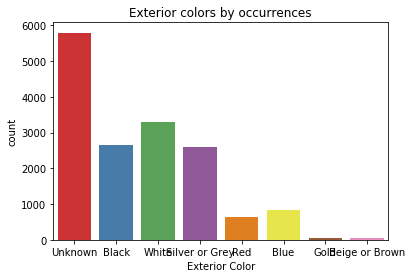

In [37]:
ax = sns.countplot(x="Exterior Color", data=cars_dataset, palette="Set1")
ax.set_title("Exterior colors by occurrences")